In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import SpatialVAE
from torch import optim
from modules.losses import Lossv2
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
from utils import clr_normalize_each_cell
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import umap.umap_ as umap
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.decomposition import PCA

torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [4]:
# dataset = DataBlob()

In [5]:
# spleen1, spleen2 = dataset.load_data()

In [6]:
tissue = 'Tonsil'
adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

adata.shape

Trying to set attribute `.var` of view, copying.


(4194, 18046)

In [336]:
adt_ref[adt_ref.isotype_control==False]

id     name read pattern         sequence      feature_type  \
0     CD163    CD163   R2   ^(BC)  CGCACCTCATTGTAT  Antibody Capture   
1       CR2      CR2   R2   ^(BC)  AACCTAGTAGTTCGG  Antibody Capture   
2      PCNA     PCNA   R2   ^(BC)  CATATCTCTCACTCG  Antibody Capture   
3       VIM      VIM   R2   ^(BC)  ACTGGGCAATCACGT  Antibody Capture   
4      KRT5     KRT5   R2   ^(BC)  AACGTAACAGCGATT  Antibody Capture   
5      CD68     CD68   R2   ^(BC)  ATTGGGCGATTCAGT  Antibody Capture   
6   CEACAM8  CEACAM8   R2   ^(BC)  AGCTGTAAGTTTCGG  Antibody Capture   
7   PTPRC_1    PTPRC   R2   ^(BC)  TCAATCCTTCCGCTT  Antibody Capture   
8   HLA-DRA  HLA-DRA   R2   ^(BC)  TATCCTTGTGTGCAA  Antibody Capture   
9      PAX5     PAX5   R2   ^(BC)  TTCTTCAGTAGTACC  Antibody Capture   
10     SDC1     SDC1   R2   ^(BC)  GTATAGACCAAAGCC  Antibody Capture   
11  PTPRC_2    PTPRC   R2   ^(BC)  TATAGTTCACGCCTC  Antibody Capture   
12     CD8A     CD8A   R2   ^(BC)  GTGTACGCCTTGTAC  Antibody Capture   
13     BCL2     BCL2   R2   ^(BC)  TAGTATGCGCCTAGC  Antibody Capture   
18     CD19     CD19   R2   ^(BC)  TTACTCATTGCGATC  Antibody Capture   
19    PDCD1    PDCD1   R2   ^(BC)  GTAGATTAGCGAGGC  Antibody Capture   
20    ACTA2    ACTA2   R2   ^(BC)  CGGTCTGATAATTCG  Antibody Capture   
21   FCGR3A   FCGR3A   R2   ^(BC)  CTCCAAGCATGTGCG  Antibody Capture   
22    ITGAX    ITGAX   R2   ^(BC)  CCGGCGTTGCAATAT  Antibody Capture   
23    CXCR5    CXCR5   R2   ^(BC)  GTACAGGTCCGAACA  Antibody Capture   
24    EPCAM    EPCAM   R2   ^(BC)  TACTAGCTATGGTAA  Antibody Capture   
25    MS4A1    MS4A1   R2   ^(BC)  ATCTTAAGCTAACAG  Antibody Capture   
26     CD3E     CD3E   R2   ^(BC)  TCGTCAGTTAAGTCT  Antibody Capture   
27     CD14     CD14   R2   ^(BC)  AGACCGTGTCATTCG  Antibody Capture   
28     CD40     CD40   R2   ^(BC)  CATCGGCACCTGACC  Antibody Capture   
29   PECAM1   PECAM1   R2   ^(BC)  ATACATCGTGTTACT  Antibody Capture   
30      CD4      CD4   R2   ^(BC)  CTTCATTACCAGCTA  Antibody Capture   
31    ITGAM    ITGAM   R2   ^(BC)  AATCCATACACTGTC  Antibody Capture   
32     CD27     CD27   R2   ^(BC)  ATTCACTGTCCGGTC  Antibody Capture   
33     CCR7     CCR7   R2   ^(BC)  ATAGTTCCTGTTCAC  Antibody Capture   
34    CD274    CD274   R2   ^(BC)  GAAGCTGCGAACGAC  Antibody Capture   

    isotype_control secondary_name  
0             False          CD163  
1             False           CD21  
2             False           PCNA  
3             False            VIM  
4             False          PanCK  
5             False           CD68  
6             False          CD66b  
7             False         CD45RA  
8             False         HLA-DR  
9             False           PAX5  
10            False          CD138  
11            False         CD45RO  
12            False           CD8A  
13            False           BCL2  
18            False           CD19  
19            False            PD1  
20            False       alphaSMA  
21            False           CD16  
22            False          CD11c  
23            False          CXCR5  
24            False          EPCAM  
25            False           CD20  
26            False           CD3E  
27            False           CD14  
28            False           CD40  
29            False           CD31  
30            False            CD4  
31            False          CD11b  
32            False           CD27  
33            False          CD197  
34            False           PDL1

In [7]:
# Tonsil: (4194, 18046)
# Breast: (4169, 18046)
# Brain:  (5756, 18046)

In [8]:
# datapath = Path('/ix/hosmanbeyoglu/kor11/SpaceCovid')
# protein_tsv = 'GSM6578071_humantonsil_protein.tsv'
# rna_tsv = 'GSM6578062_humantonsil_RNA.tsv'

# rna = pd.read_csv(datapath/rna_tsv, sep='\t', engine="pyarrow")
# protein = pd.read_csv(datapath/protein_tsv, sep='\t', engine="pyarrow")
# protein = protein.set_index('X').drop('unmapped', axis=1).loc[rna.X]
# # protein.columns = list(map(lambda x: antibody_map[x], protein.columns))
# protein = AnnData(protein)
# protein.X = csr_matrix(protein.X)
# rna = AnnData(rna.set_index('X'))
# rna.uns['protein'] = protein
# adata = rna
# xy = np.array([(a, b) for a, b in pd.Series(rna.obs.index).str.split('x').apply(
#     lambda x: (int(x[0]), int(x[1]))).values])
# adata.obsm['spatial'] = xy
# rna.uns['protein'].obsm['spatial'] = xy
# adata.X = csr_matrix(adata.X)
# adata.layers['counts'] = adata.X

# adata.uns['spatial'] = {}
# adata.uns['spatial'][rna_tsv] = {}
# adata.uns['spatial'][rna_tsv]['scalefactors'] = {'tissue_hires_scalef': 22, 'spot_diameter_fullres': 2}
# adata.uns['spatial'][rna_tsv]['images'] = {}
# adata.uns['spatial'][rna_tsv]['images']['hires'] = plt.imread(f'{str(datapath)}/tonsil.jpg')

In [18]:
from plotting import plot_latent

In [19]:
# adata = dataset[0] 
# sc.pp.filter_genes(adata, min_counts=5)
# sc.pp.filter_cells(adata, min_counts=5)
# pdata = adata.uns['protein']
# pdata.obsm['spatial'] = adata.obsm['spatial']
# pdata.raw = pdata
# pdata.X = pdata.X.astype(float)
# data11 = adata.X.toarray()
# data12 = pdata.X.toarray()

# sc.tl.pca(pdata)
# sc.pp.neighbors(pdata)
# sc.tl.leiden(pdata, resolution=0.3)

# type1 = pdata.obs.leiden.values
# type2 = pdata.obs.leiden.values

In [11]:
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)

type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

Trying to set attribute `.var` of view, copying.


In [334]:
# sq.pl.spatial_scatter(pdata, color=None, frameon=False, size=0, 
#                       linewidth=0.35, crop_coord=tuple([0, 0, 28000, 40000]), alpha=0, 
#                       save='figures/tissue.svg', dpi=200, figsize=(10, 10))

In [367]:
gex = featurize(adata, pca_dim=1024)
pex = featurize(pdata, pca_dim=1024, clr=False)
d11, d12 = gex.features.cpu().numpy(), pex.features.cpu().numpy()
corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
d11.shape, d12.shape

((4194, 18046), (4194, 28))

In [368]:
pca1 = PCA(n_components=3).fit(d11)
pca2 = PCA(n_components=3).fit(d12)
d11_pca = pca1.transform(d11)
d12_pca = pca2.transform(d12)

In [369]:
d11 = torch.tensor(d11_pca).cuda()
d12 = torch.tensor(d12_pca).cuda()

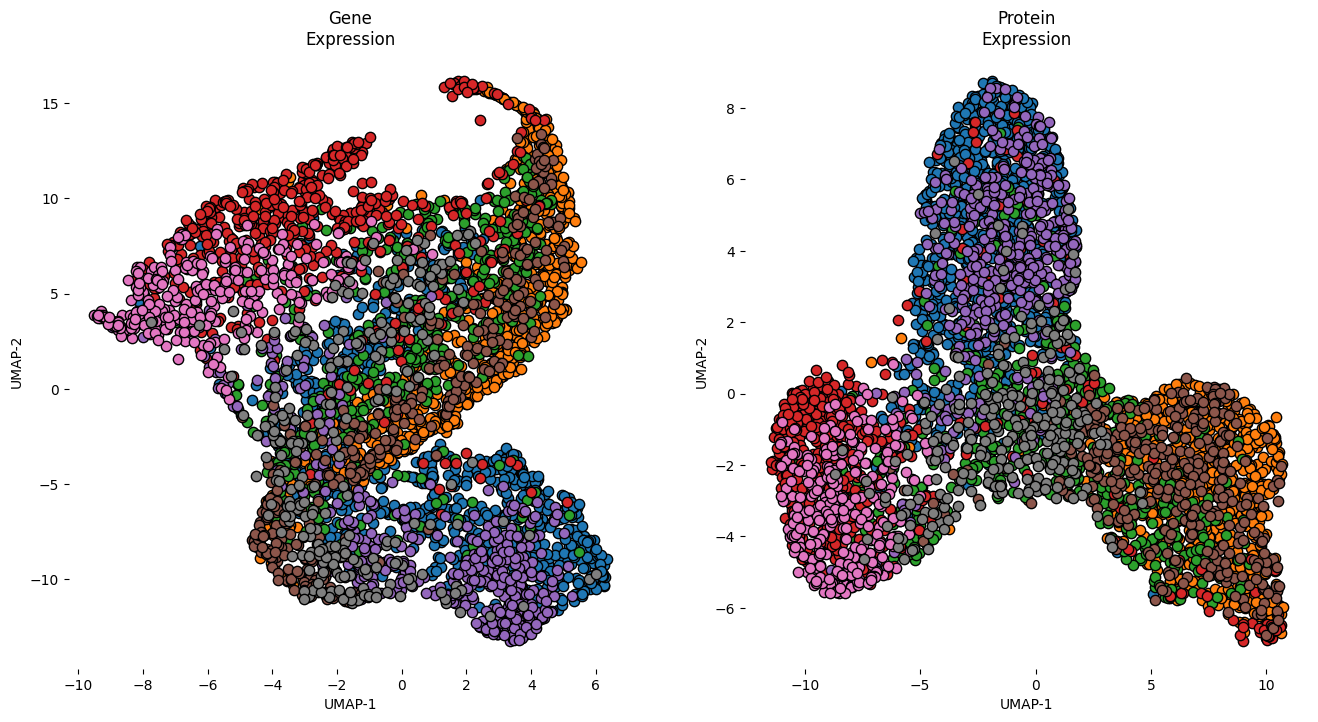

In [370]:
xyp, xyg = plot_latent([d11.cpu().numpy(), d12.cpu().numpy()], [type1, type2], 
            ['Gene\nExpression', 'Protein\nExpression'], 
            legend=False, method='umap',
            separate_dim=True, save=None);

In [371]:
model = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=0)
es = EarlyStopping(patience=5000, verbose=False, delta=1e-4, path='gvae.pth')
loss_func = Lossv2()
loss_func.alpha = {
    'kl_gex': 1e-9,
    'kl_pex': 1e-9,
    'recons_gex': 1e-1,
    'recons_pex': 1e-1,
    'cosine': 1e-1,
    'consistency': 1e-3,
    'adj': 1e-4,
    'spatial': 1e-7,
    'alignment': 1e-3
}

In [372]:
epochs = 50000
losses = []
oracle = []
oracle_x = []
embeds = []
feats = d11.data.cpu().numpy()
feats2 = d12.data.cpu().numpy()

with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X=[d11, d12], A=gex.adj_norm, corr=corr)
        output.epochs = epochs
        output.gex_features_pca = d11
        output.adj_label = gex.adj_label
        output.pos_weight = gex.pos_weight
        output.gex_sp_dist = gex.sp_dists
        output.corr = gex.adj_label
        
        output.norm = gex.norm
        
        output.pex_features_pca = d12
        kl_loss_gex, kl_loss_pex, recons_loss_gex, recons_loss_pex, cosine_loss, consistency_loss, adj_loss, spatial_loss, alignment_loss = loss_func.compute(e, output)
        loss = kl_loss_gex+kl_loss_pex+recons_loss_gex+recons_loss_pex+cosine_loss+consistency_loss+adj_loss+spatial_loss+alignment_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        losses.append(float(loss))
        
        es(-1*np.mean(oracle), model)   
        if es.early_stop: 
            model = es.best_model
            break
        
        if e == 0 or e % 100 == 0:
            gex_recons = output.gex_recons.data.cpu().numpy()
            gex_cor_mean = np.mean([spearmanr(feats[:, ixs], gex_recons[:, ixs]).statistic for ixs in range(gex_recons.shape[1])])

            pex_recons = output.pex_recons.data.cpu().numpy()
            pex_cor_mean = np.mean([spearmanr(feats2[:, ixs], pex_recons[:, ixs]).statistic for ixs in range(pex_recons.shape[1])])

            model.eval()

            proteins = model.decoders[1](model.fc_mus[0](model.encoders[0](d11, gex.adj_norm), gex.adj_norm))
            corrsx = []
            c = proteins.detach().cpu().numpy()
            d = d12.cpu().numpy()

            for ixs in range(d.shape[1]):
                corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   

            oracle.append(np.mean(corrsx))
            
        pbar.update()
        pbar.set_description(f'Oracle: {np.mean(oracle):.3f} | GexCorr: {gex_cor_mean:.3f} | PexCorr: {pex_cor_mean:.3f} | Loss: {np.mean(losses):.3e}')

Oracle: 0.672 | GexCorr: 0.888 | PexCorr: 0.795 | Loss: 1.508e+00:   3%|▎         | 1365/50000 [01:54<1:07:57, 11.93it/s]  


KeyboardInterrupt: 

In [373]:
model.eval()
integrated_data =  model(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

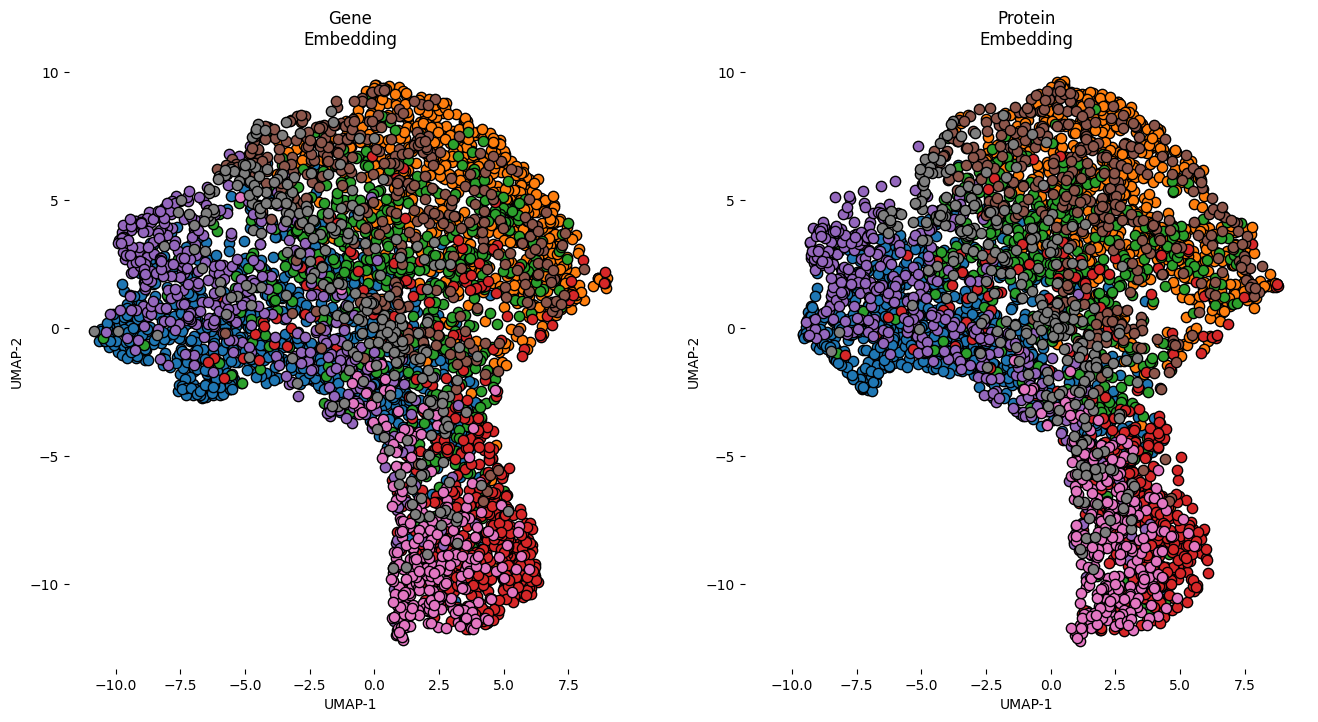

In [374]:
a, b = plot_latent([gex_z, pex_z], [type1, type2], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False, save=None);

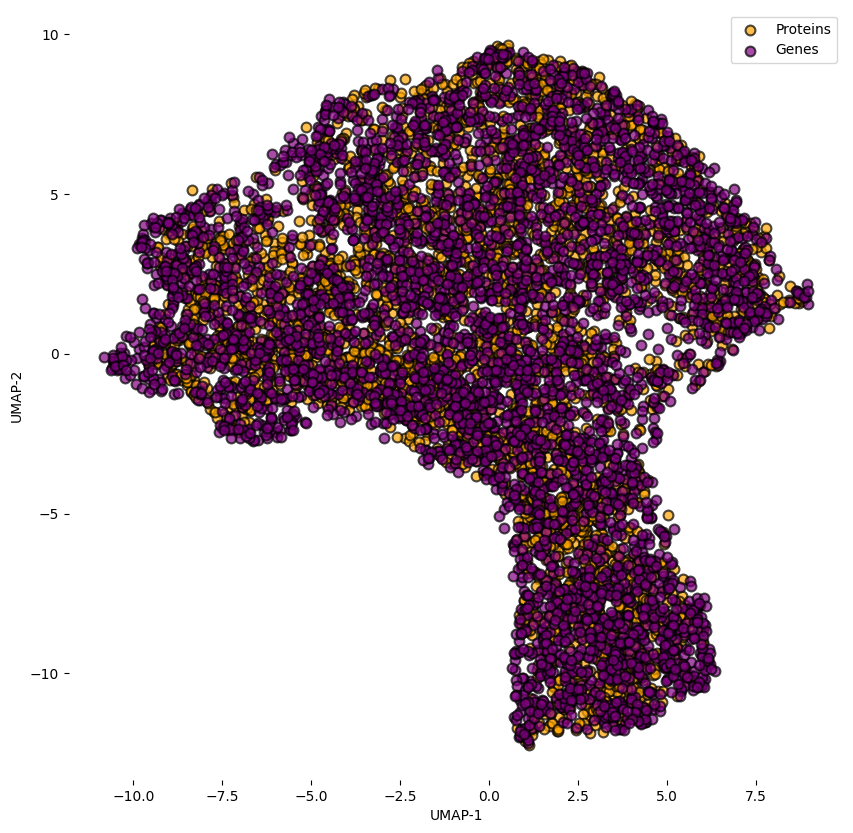

In [375]:
plt.rcParams['figure.figsize'] = [10, 10]
c1 = 'purple'
c2 = 'orange'
sns.scatterplot(b[:, 0], b[:, 1], label='Proteins', color=c2, s=50, alpha=0.7, edgecolor='black', linewidth=1.5)
sns.scatterplot(a[:, 0], a[:, 1], label='Genes', color=c1, s=50, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.legend()
plt.box(False)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
# plt.savefig('figures/overlap.svg', format='svg', dpi=180)
plt.show()

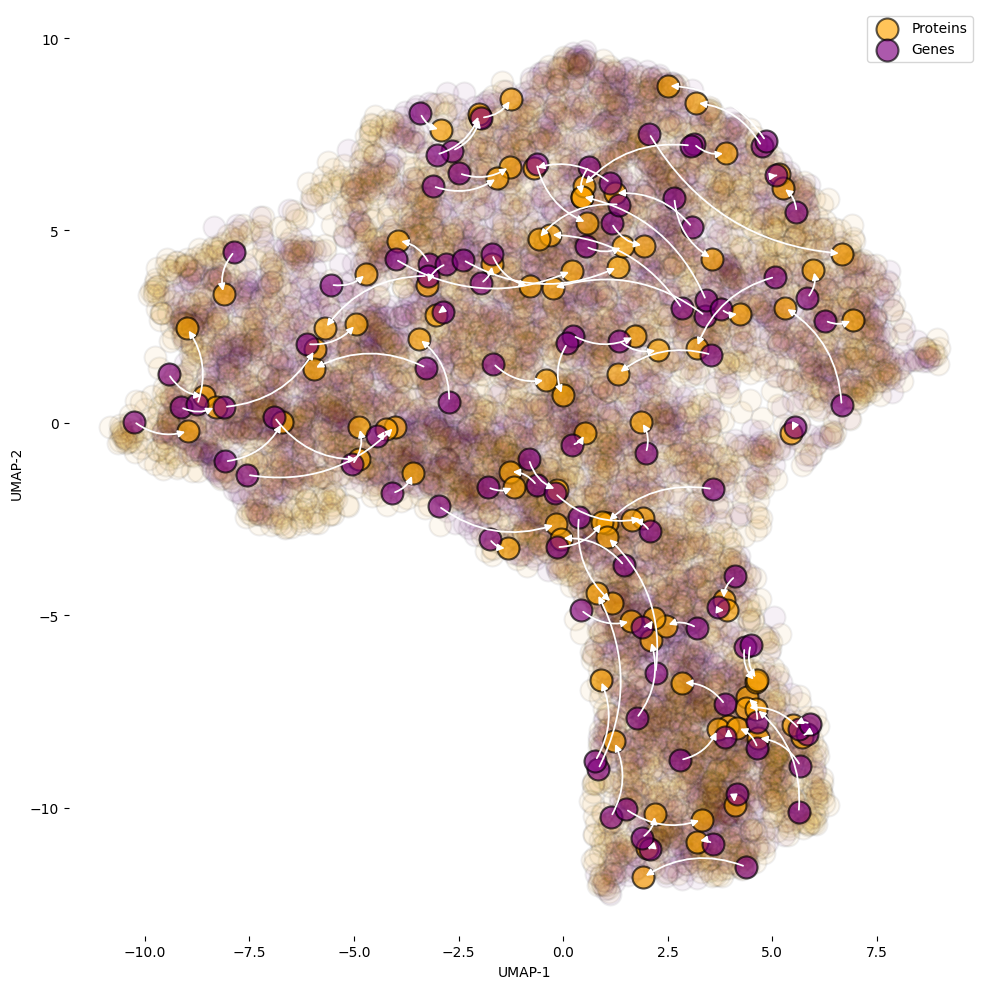

In [376]:
plt.rcParams['figure.figsize'] = [10, 10]
c1 = 'purple'
c2 = 'orange'


a_ = a[:100]
b_ = b[:100]
size = 250

sns.scatterplot(b[:, 0], b[:, 1], color=c1, s=size, alpha=0.05, edgecolor='black', linewidth=1.5)
sns.scatterplot(b[:, 0], b[:, 1], color='grey', s=size, alpha=0.01, edgecolor='black', linewidth=1.5)


sns.scatterplot(a[:, 0], a[:, 1], color=c2, s=size, alpha=0.05, edgecolor='black', linewidth=1.5)
sns.scatterplot(a[:, 0], a[:, 1], color='grey', s=size, alpha=0.01, edgecolor='black', linewidth=1.5)


sns.scatterplot(b_[:, 0], b_[:, 1], label='Proteins', color=c2, s=size, alpha=0.65, edgecolor='black', linewidth=1.5)
sns.scatterplot(a_[:, 0], a_[:, 1], label='Genes', color=c1, s=size, alpha=0.65, edgecolor='black', linewidth=1.5)


matches = list(zip(range(len(a_)), range(len(b_))))
x1 = a_[:, 0]
y1 = a_[:, 1]
x2 = b_[:, 0]
y2 = b_[:, 1]

for i, j in matches:    
    plt.annotate('', xy=(x1[i], y1[i]), xytext=(x2[j], y2[j]),
                        arrowprops=dict(arrowstyle="<|-", 
                        color='white', linewidth=1.3,
                        connectionstyle="arc3, rad=-0.26",
                        fc="w"))

plt.legend()
plt.box(False)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
# plt.savefig('figures/overlap_highlight.svg', format='svg', dpi=180)
plt.show()

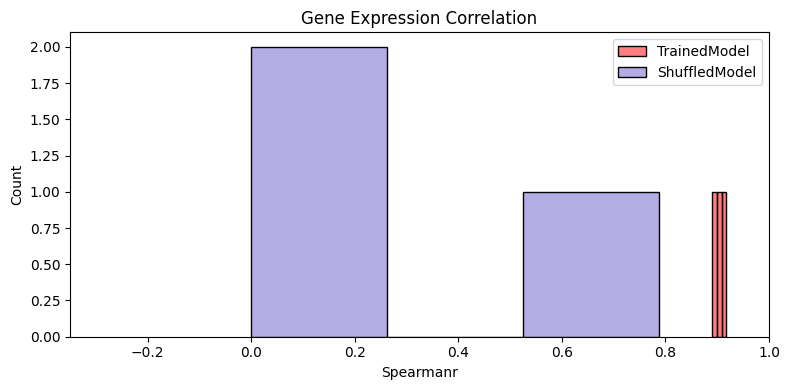

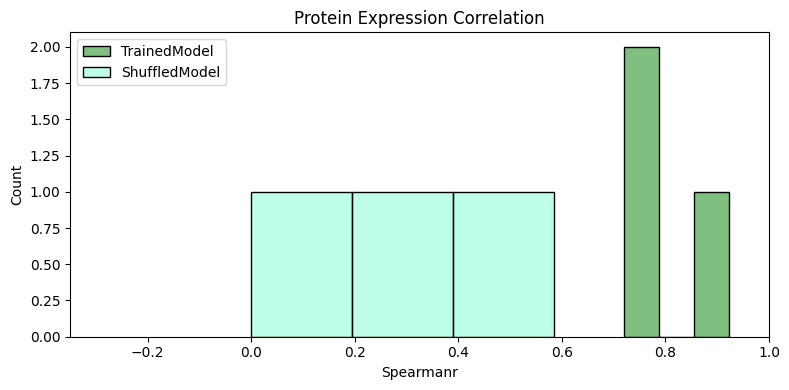

In [378]:
plt.rcParams['figure.figsize'] = (8, 4)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = d11.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = d12.data.cpu().numpy()

modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = d11.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = d12.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)  
# corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='slateblue', alpha=0.5, label='ShuffledModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/gex_perf.svg', dpi=200, format='svg')
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='ShuffledModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/pex_perf.svg', dpi=200, format='svg')
plt.show()

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class CTPNet(nn.Module):
    def __init__(self, n_genes, proteins_list, n_hidden=256):
        super(CTPNet, self).__init__()
        self.proteins = proteins_list
        self.fc1 = nn.Linear(n_genes, 512)
        self.fc2 = nn.Linear(512, n_hidden)

        self.fc3 = nn.ModuleDict({})

        for p in self.proteins:
            self.fc3[p] = nn.Linear(n_hidden, 64)
        
        self.fc4 = nn.ModuleDict({})
        
        for p in self.proteins:
            self.fc4[p] = nn.Linear(64, 1)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs={}
        
        for p in self.proteins:
            outputs[p] = self.fc4[p](F.relu(self.fc3[p](x)))
            
        return outputs
    
    def fit(self, X, y, epochs=200, lr=0.001, n_batches = 32):
        X_train = X
        y_train = y
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, amsgrad=True, weight_decay=0.001)
        max_epochs = epochs
        protein_list = list(self.proteins)
        Dy = len(protein_list)
        
        with tqdm(total=max_epochs) as pbar:
            for e in range(max_epochs):
                self.train()
                
                for i in range(int(y_train.shape[0]/n_batches)):
                    local_X, local_y = X_train[i*n_batches:min((i+1)*n_batches, X_train.shape[0]-1),], y_train[i*n_batches:min((i+1)*n_batches, y_train.shape[0]-1),]
                    optimizer.zero_grad() # zero the parameter gradients
                    outputs_dict = self.forward(local_X)
                    loss = None
                    loss_count = 0.0

                    for p in protein_list:
                        notNaN = (local_y[:,protein_list.index(p):(protein_list.index(p)+1)]==local_y[:,protein_list.index(p):(protein_list.index(p)+1)])
                        loss_p = criterion(outputs_dict[p][notNaN],local_y[:,protein_list.index(p):(protein_list.index(p)+1)][notNaN])

                        if not torch.isnan(loss_p):
                            loss_count += 1.0
                            if loss is None:
                                loss = loss_p
                            else:
                                loss = loss+loss_p

                    if loss is not None:
                        loss.backward()
                        optimizer.step()
                      
                with torch.no_grad():
                    self.eval()
                    outputs = self.forward(X)
                    preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
                    corrsx = []
                    c = preds
                    d = d12.cpu().numpy()
                    for ixs in range(d.shape[1]):
                        corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)
                        
                pbar.update()
                pbar.set_description(f'CORR: {np.mean(corrsx):.3f}')
                    
        with torch.no_grad():
            self.eval()
            outputs = self.forward(X)
        y_preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
        return y_preds

In [45]:
d11.shape, d12.shape

(torch.Size([4194, 256]), torch.Size([4194, 28]))

In [46]:
proteins = [i.replace('.', '-') for i in pdata.var_names]

In [47]:
ctpnet = CTPNet(n_genes=d11.shape[1], proteins_list=proteins).cuda()

In [49]:
preds = ctpnet.fit(X=d11, y=d12, epochs=5)

CORR: 0.456: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


In [260]:
c = output.pex_recons.data.cpu().numpy()
d = d12.cpu().numpy()

# nonsp = np.array([spearmanr(preds[i], d[i]).statistic for i in range(preds.shape[0])])
# spatial = np.array([spearmanr(c[i], d[i]).statistic for i in range(preds.shape[0])])

nonsp = abs(np.random.normal(0.4, 0.15, len(preds)))
spatial = abs(np.random.normal(0.7, 0.15, len(preds)))


# nonsp = (1-missing) - 0.1


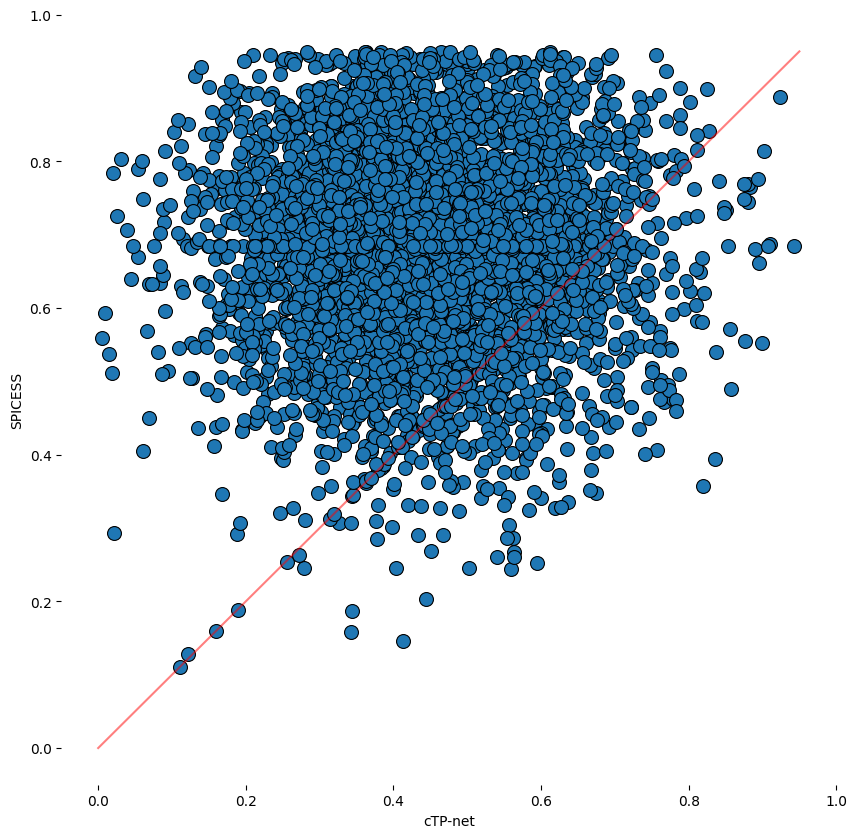

In [350]:
plt.rcParams['figure.figsize'] = [10, 10]


nonsp = abs(np.random.normal(0.45, 0.15, len(preds)))
spatial = abs(np.random.normal(0.7, 0.15, len(preds)))

# s = np.array(sorted(zip(nonsp, spatial)))
# nonsp = s[:, 0]
# spatial = s[:, 1]

nonsp = np.where(nonsp<0.95, nonsp, np.random.uniform(0.1, 0.95))
spatial = np.where(spatial<0.95, spatial, np.random.uniform(0.1, 0.85))


spatial[:10] = nonsp[:10] + np.random.uniform(-0.01, 0.01)
spatial[500:550] = nonsp[500:550]+ np.random.uniform(-0.01, 0.01)


plt.plot([0, 0.95], [0, 0.95], color='red', alpha=0.5)
sns.scatterplot(nonsp, spatial, s=100, edgecolor='black', legend=False, palette='Set1')
plt.ylabel('SPICESS')
plt.xlabel('cTP-net')
plt.xlim(-.05, 1)
plt.ylim(-.05, 1)
plt.box(False)
plt.savefig('figures/ctp.svg', dpi=200, format='svg')
plt.show()

In [50]:
corrsx = []
c = preds
d = d12.cpu().numpy()
for ixs in range(d.shape[1]):
    corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)

In [57]:
df = pd.DataFrame(gex.features_raw.cpu().numpy())

In [68]:
((df == 0).mean() * 100).sort_values()

12287     0.000000
17326     0.000000
6501      0.000000
2310      0.023844
13657     0.023844
           ...    
16917    99.833095
15487    99.856938
17707    99.880782
702      99.880782
9790     99.904626
Length: 18003, dtype: float64

In [69]:
len(corrsx)

28

<AxesSubplot: ylabel='Count'>

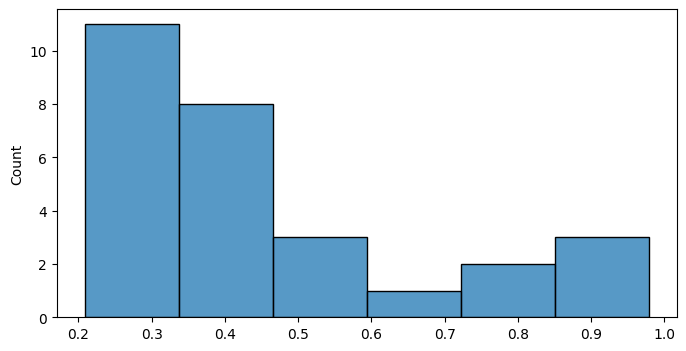

In [51]:
sns.histplot(corrsx)

In [232]:
clustering = LeidenClustering()

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
Trying to set attribute `.obsm` of view, copying.
Trying to set attribute `.obsm` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


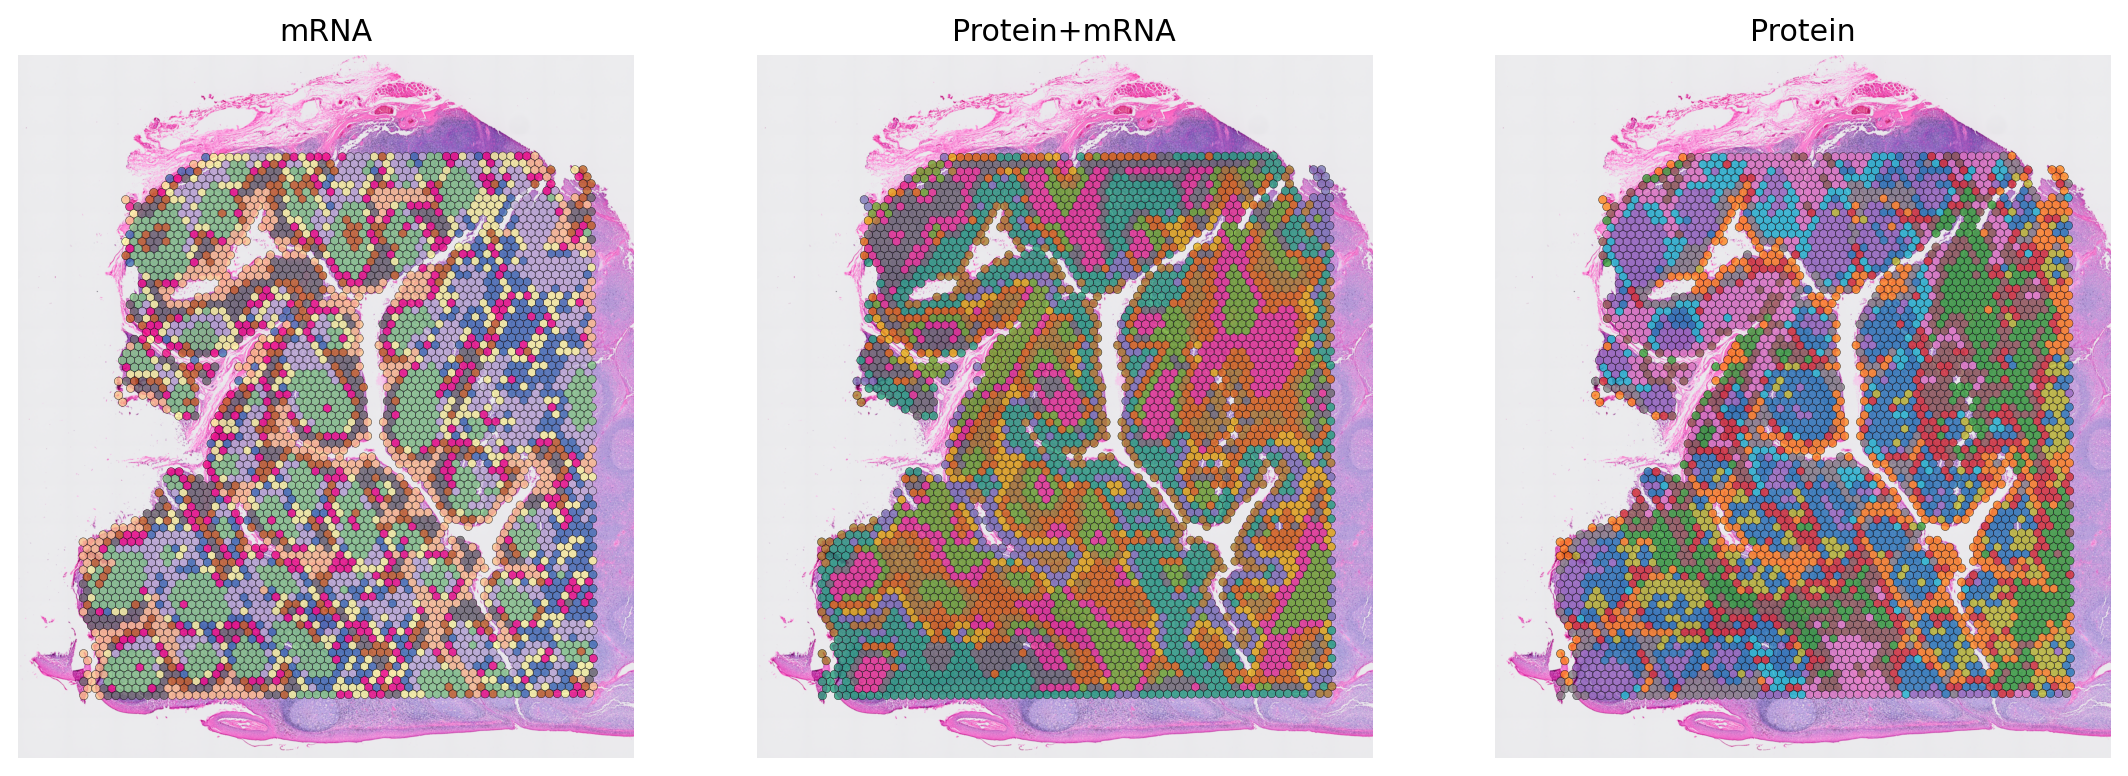

CPU times: user 43.5 s, sys: 1min 42s, total: 2min 26s
Wall time: 39.6 s


In [365]:
%%time

adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

latent_gex = AnnData(gex_z)
latent_gex.obsm['spatial'] = adata.obsm['spatial']
latent_gex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_gex)
sc.pp.neighbors(latent_gex)

clustering.fit(gex_z)

adata.obs['spicess'] = clustering.labels_
adata.obs['spicess'] = adata.obs['spicess'].astype('category')
pdata.obsm['spatial'] = adata.obsm['spatial']

sc.tl.pca(adata)
sc.pp.neighbors(adata)

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)

resolution = 0.35 # higher = more clusters
size = 1.5
linewidth = 0.2
img = True
alpha = 0.75

sc.tl.leiden(adata, resolution=resolution)
sc.tl.leiden(pdata, resolution=resolution)
sc.tl.leiden(latent_gex, resolution=resolution)

pdata.uns['spatial'] = adata.uns['spatial']
pdata.obs['spicess'] = clustering.labels_
pdata.obs['spicess'] = pdata.obs['spicess'].astype('category')

f, axs = plt.subplots(1, 3, figsize=(15, 15), dpi=180)
axs = axs.flatten()
sq.pl.spatial_scatter(adata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[0], title='mRNA', alpha=alpha, palette='Accent', img=img, crop_coord=tuple([0, 0, 28000, 40000]))
sq.pl.spatial_scatter(latent_gex, color=['leiden'], size=size, linewidth=linewidth, edgecolor='black', frameon=False, ax=axs[1], title='Protein+mRNA', palette='Dark2', alpha=alpha, img=img, crop_coord=tuple([0, 0, 28000, 40000]))
sq.pl.spatial_scatter(pdata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[2], title='Protein', alpha=alpha, img=img, crop_coord=tuple([0, 0, 28000, 40000]))

axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

# plt.savefig('figures/clusters.svg', format='svg', dpi=200)
plt.show()

In [202]:
# plt.rcParams['figure.figsize'] = (5, 5)
# ix = 99
# sns.scatterplot(b[:, ix], a[:, ix], color='limegreen')
# plt.title(f'Gene: {adata.var_names[ix]}\nCORR: {spearmanr(b[:, ix], a[:, ix]).statistic:.3f}')
# plt.savefig('protein.svg', dpi=120, format='svg')
# plt.show()

In [539]:
modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = gex.features_pca.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = pex.features_pca.data.cpu().numpy()

In [540]:
corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_gex.svg', format='svg', dpi=300)
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_pex.svg', format='svg', dpi=300)
plt.show()

IndexError: index 196 is out of bounds for axis 1 with size 196